# Alternative Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## 1. Back-Propagation

### 1.1 Generowanie zbioru danych 2D z nieliniowymi granicami klas oraz podział na zbiór treningowy i testowy

Wygenerujemy dane 2D dla trzech klas:
- klasa 0: punkty rozmieszczone w centrum (mała kula),
- klasa 1: pierścień otaczający klasę 0,
- klasa 2: większy pierścień otaczający obie wcześniejsze klasy.

Na końcu dzielimy dane na zbiór treningowy i testowy (80/20).


Ogólna funkcja do generowania danych w formie okręgu

In [2]:
def generate_circle_data(n_samples, radius_min, radius_max, label, noise_std=0.05):
    r = np.sqrt(np.random.uniform(radius_min**2, radius_max**2, n_samples))
    theta = np.random.uniform(0, 2*np.pi, n_samples)
    x = r * np.cos(theta) + np.random.normal(0, noise_std, n_samples)
    y = r * np.sin(theta) + np.random.normal(0, noise_std, n_samples)
    return np.stack((x, y), axis=1), np.full(n_samples, label)


In [3]:
np.random.seed(42)
n_samples = 300
noise_std = 0.1

Generowanie danych z szumem, a także ich konkatenacja i podział na zbiory treningowy i testowy

In [4]:
X0, y0 = generate_circle_data(n_samples, 0.0, 0.5, 0, noise_std=noise_std)
X1, y1 = generate_circle_data(n_samples, 0.8, 1.2, 1, noise_std=noise_std)
X2, y2 = generate_circle_data(n_samples, 1.6, 2.0, 2, noise_std=noise_std)

X = np.vstack((X0, X1, X2))
y = np.concatenate((y0, y1, y2))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

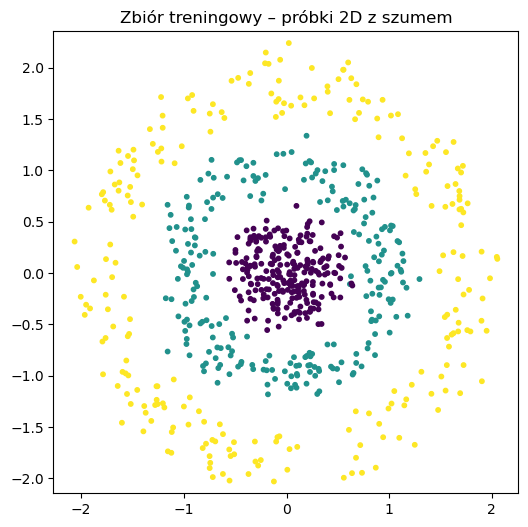

In [5]:

plt.figure(figsize=(6, 6))
plt.title("Zbiór treningowy – próbki 2D z szumem")
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="viridis", s=10)
plt.axis('equal')
plt.show()

### 1.2 Trening jednowarstwowej sieci MLP do klasyfikacji trzech klas

Tworzymy i trenujemy prostą sieć neuronową MLP z jedną warstwą ukrytą (z ReLU). Sieć przyjmuje dane 2D jako wejście i uczy się klasyfikować je do trzech klas.


In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

Noramlizacja danych oraz konwersja do tensora

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


Zdefiniowanie sieci oraz inicjalizacja modelu

In [8]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=10, output_dim=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

model = SimpleMLP()

Funkcja kosztu, optymalizator oraz faktyczny trening sieci

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 200
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

Ewaluacja modelu

In [10]:
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor).argmax(dim=1).numpy()
    y_pred_train = model(X_train_tensor).argmax(dim=1).numpy()

print("Train accuracy:", accuracy_score(y_train, y_pred_train))
print("Test accuracy:", accuracy_score(y_test, y_pred_test))

Train accuracy: 0.9958333333333333
Test accuracy: 0.9833333333333333


Jednowarstwowa sieć MLP osiągnęła bardzo wysoką dokładność:
- **Train accuracy**: 99.6 %
- **Test accuracy**: 98.3 %

Wynik ten świadczy o skutecznym nauczeniu się nieliniowej separacji klas oraz dobrej generalizacji modelu.


### 1.3 Wizualizacja danych treningowych i testowych z centroidami neuronów warstwy ukrytej

Wyświetlamy dwa wykresy:
- Scatterplot próbek treningowych,
- Scatterplot próbek testowych.

Na obu zaznaczamy centroidy neuronów warstwy ukrytej jako punkty o współrzędnych odpowiadających wagom `fc1.weight`, a wokół każdego neuronu rysujemy okrąg o promieniu równym jego biasowi.


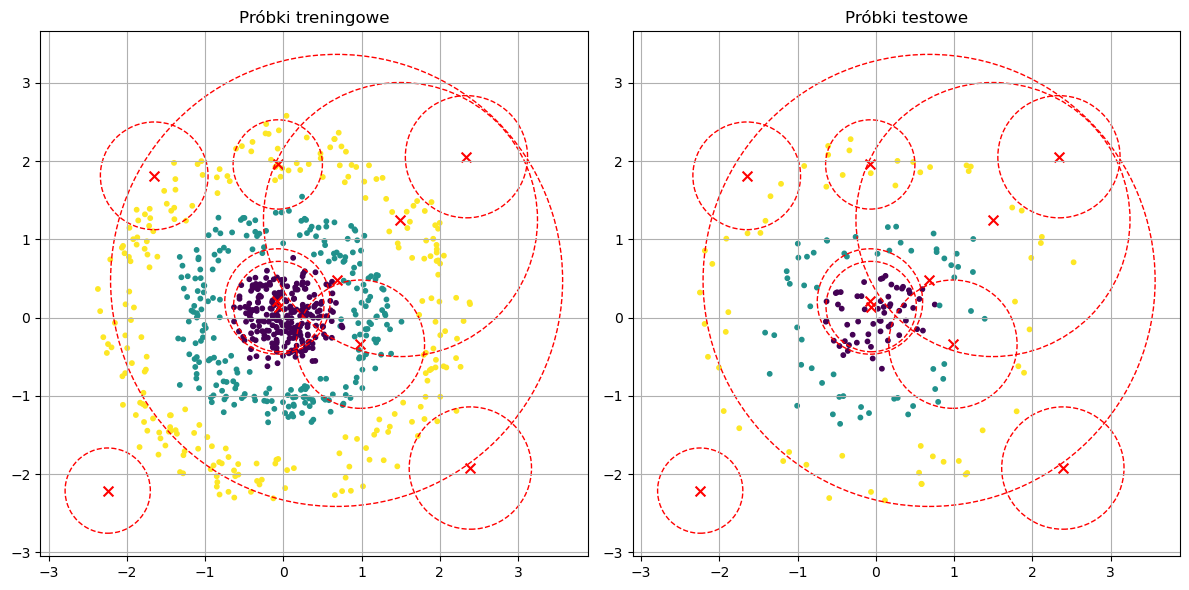

In [11]:
import matplotlib.patches as patches

with torch.no_grad():
    weights = model.fc1.weight.numpy()
    biases = model.fc1.bias.numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
titles = ["Próbki treningowe", "Próbki testowe"]
datasets = [(X_train_scaled, y_train), (X_test_scaled, y_test)]

for ax, (X_set, y_set), title in zip(axes, datasets, titles):
    ax.set_title(title)
    scatter = ax.scatter(X_set[:, 0], X_set[:, 1], c=y_set, cmap="viridis", s=10)
    for i in range(weights.shape[0]):
        cx, cy = weights[i]
        bias = np.abs(biases[i])
        ax.scatter(cx, cy, color="red", marker="x", s=50)
        circle = patches.Circle((cx, cy), bias, color='red', fill=False, linestyle='--')
        ax.add_patch(circle)
    ax.axis('equal')
    ax.grid(True)

plt.tight_layout()
plt.show()


Wykresy przedstawiają dane treningowe i testowe wraz z neuronami warstwy ukrytej sieci MLP. Neurony zobrazowano jako czerwone krzyżyki (wagi `fc1.weight[i]`) oraz okręgi o promieniu równym wartości biasu (`|bias[i]|`), które wskazują obszar ich potencjalnej aktywacji.

Większość neuronów znajduje się w pobliżu danych i aktywuje się w istotnych obszarach przestrzeni wejściowej. Część z nich jednak pozostaje poza zasięgiem danych — ich wyjścia przed funkcją ReLU są stale ujemne, co prowadzi do braku aktywacji i aktualizacji podczas treningu. Zjawisko to jest typowe dla sieci z ReLU i może wynikać z nieoptymalnej inicjalizacji lub zbyt dużej liczby neuronów.


### 1.4 Rozkład centroidów warstwy wyjściowej na przestrzeni reprezentacji z warstwy ukrytej

Przekształcamy dane wejściowe za pomocą warstwy ukrytej (`ReLU(FC1(x))`), a następnie rysujemy rozkład danych w tej przestrzeni. Na tym tle pokazujemy również centroidy neuronów warstwy wyjściowej — są to wagi warstwy `fc2`.

Dzięki temu zobaczymy, jak warstwa wyjściowa „czyta” przestrzeń cech utworzoną przez warstwę ukrytą.


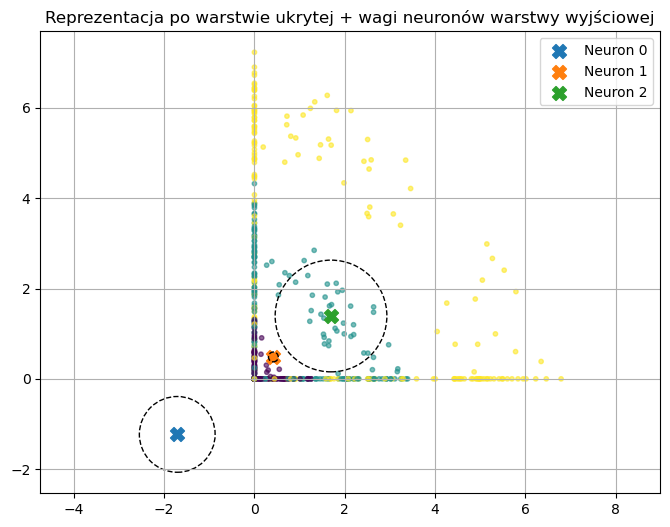

In [12]:
with torch.no_grad():
    hidden_repr_train = model.relu(model.fc1(X_train_tensor)).numpy()

output_weights = model.fc2.weight.detach().numpy()
output_biases = model.fc2.bias.detach().numpy()

plt.figure(figsize=(8, 6))
plt.title("Reprezentacja po warstwie ukrytej + wagi neuronów warstwy wyjściowej")

plt.scatter(hidden_repr_train[:, 0], hidden_repr_train[:, 1], c=y_train, cmap="viridis", s=10, alpha=0.6)

for i in range(output_weights.shape[0]):
    cx, cy = output_weights[i, 0], output_weights[i, 1]
    plt.scatter(cx, cy, marker='X', s=100, label=f'Neuron {i}')
    circle = patches.Circle((cx, cy), np.abs(output_biases[i]), color='black', fill=False, linestyle='--')
    plt.gca().add_patch(circle)

plt.legend()
plt.axis('equal')
plt.grid(True)
plt.show()

Na wykresie przedstawiono dane treningowe po przejściu przez warstwę ukrytą (`ReLU(fc1(x))`) oraz centroidy neuronów warstwy wyjściowej, czyli wagi `fc2.weight`. 

Każdy neuron wyjściowy zaznaczony jest kolorowym krzyżykiem w przestrzeni ukrytej. Czarny okrąg wokół niego symbolizuje wartość bezwzględną biasu (`|fc2.bias|`), która wpływa na położenie granicy decyzyjnej.

Choć pozycje neuronów nie odpowiadają bezpośrednio centrom danych, ich rozmieszczenie odzwierciedla sposób, w jaki sieć nauczyła się separować klasy. Wagi warstwy wyjściowej działają jako detektory aktywacji cech utworzonych przez warstwę ukrytą i są dostosowane do minimalizacji błędu klasyfikacji.

### 1.5 Wizualizacja wielowymiarowej reprezentacji (warstwa ukryta) przy użyciu t-SNE

Wyliczamy reprezentację danych po warstwie ukrytej (dla zbioru treningowego i testowego), a następnie redukujemy ich wymiar do 2D za pomocą algorytmu t-SNE. Pozwala to zobaczyć, jak dane są separowane w przestrzeni reprezentacji, którą wykorzystuje warstwa wyjściowa.


In [13]:
with torch.no_grad():
    hidden_train = model.relu(model.fc1(X_train_tensor)).numpy()
    hidden_test = model.relu(model.fc1(X_test_tensor)).numpy()


Połączenie danych w jeden zbiór, redukcja wymiaru z użyciem t-SNE i podział z powrotem

In [14]:
from sklearn.manifold import TSNE

combined_hidden = np.vstack([hidden_train, hidden_test])
combined_labels = np.concatenate([y_train, y_test])
split_index = len(y_train)

tsne = TSNE(n_components=2, random_state=42, perplexity=30)
combined_embedded = tsne.fit_transform(combined_hidden)

tsne_train = combined_embedded[:split_index]
tsne_test = combined_embedded[split_index:]

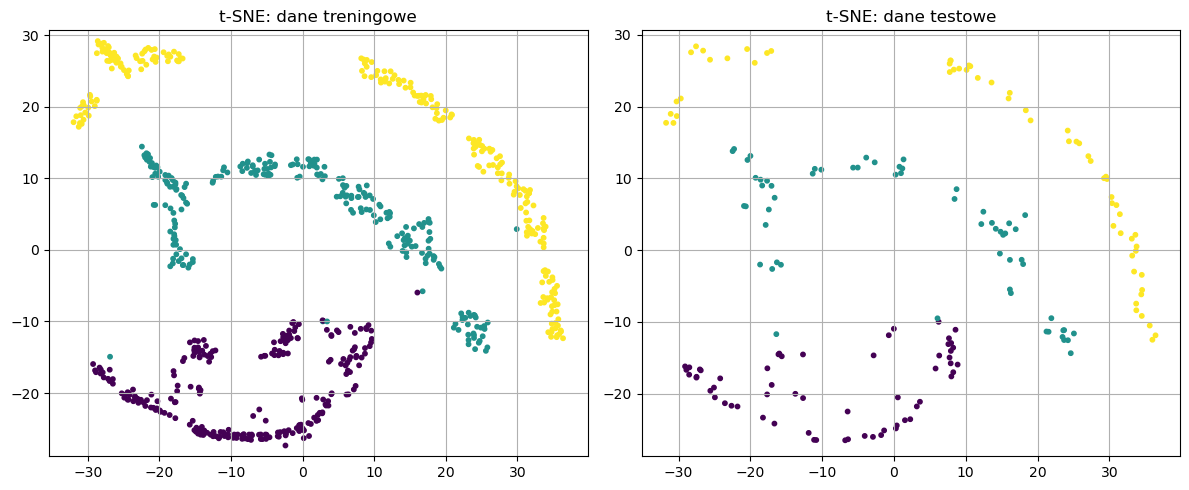

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].set_title("t-SNE: dane treningowe")
axes[0].scatter(tsne_train[:, 0], tsne_train[:, 1], c=y_train, cmap="viridis", s=10)
axes[0].axis('equal')
axes[0].grid(True)

axes[1].set_title("t-SNE: dane testowe")
axes[1].scatter(tsne_test[:, 0], tsne_test[:, 1], c=y_test, cmap="viridis", s=10)
axes[1].axis('equal')
axes[1].grid(True)

plt.tight_layout()
plt.show()

Powyższe wykresy przedstawiają wynik redukcji wymiarów reprezentacji `ReLU(fc1(x))` za pomocą algorytmu t-SNE. Osobno pokazano dane treningowe oraz testowe.

Dzięki t-SNE względnie dobrze widoczne są wyodrębnione klastry odpowiadające trzem klasom, co świadczy o tym, że warstwa ukryta sieci całkiem skutecznie przekształca dane wejściowe do postaci umożliwiającej liniową separację klas.

Rozkład danych testowych jest zbliżony do treningowych, co sugeruje, że sieć nauczyła się uogólniać, a nie jedynie zapamiętywać dane. To potwierdza skuteczność reprezentacji wyuczonej przez MLP.


## 2. Forward Training

### 2.1 Generowanie nowego zbioru danych 2D o nieliniowych granicach (innego niż poprzednio)

Generujemy inny nieliniowy zbiór danych — wykorzystamy trzy klasy ułożone w strukturę przypominającą "księżyce" oraz zwykłą chmurę punktów. Analogicznie do pierwszego zadania dzielimy dane na zbiór treningowy i testowy.


In [16]:
from sklearn.datasets import make_moons, make_classification

def generate_custom_nonlinear_data(n_samples_per_class=300, noise=0.1):
    X1, y1 = make_moons(n_samples=2 * n_samples_per_class, noise=noise)

    X2, _ = make_classification(n_samples=n_samples_per_class, n_features=2, n_informative=2, 
                                 n_redundant=0, n_clusters_per_class=1, class_sep=1.5)
    X2 = X2 * 0.5 + [2, -1]
    y2 = np.full(n_samples_per_class, 2)

    X = np.vstack([X1, X2])
    y = np.concatenate([y1, y2])
    return X, y

Generowanie danych oraz ich podział na zbiory testowy i treningowy

In [17]:
np.random.seed(42)
X_new, y_new = generate_custom_nonlinear_data()

X_train2, X_test2, y_train2, y_test2 = train_test_split(X_new, y_new, test_size=0.2, stratify=y_new, random_state=42)

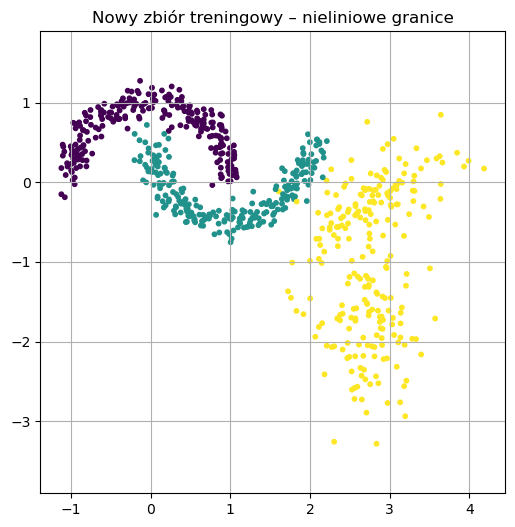

In [18]:
plt.figure(figsize=(6, 6))
plt.title("Nowy zbiór treningowy – nieliniowe granice")
plt.scatter(X_train2[:, 0], X_train2[:, 1], c=y_train2, cmap="viridis", s=10)
plt.axis('equal')
plt.grid(True)
plt.show()

### 2.2 Metoda znajdowania centroidów i biasów do inicjalizacji warstwy ukrytej

- Dzielimy dane treningowe według etykiet klas.
- Dla każdej klasy i dodatkowych podgrup (np. poprzez k-means) wyznaczamy centroidy jako potencjalne wagi neuronów warstwy ukrytej.
- Biasy dobieramy jako średni dystans punktów klasy do swojego centroidu (odpowiada promieniowi okręgu w poprzednim zadaniu).

Ta metoda pozwala zasugerować rozkład w przestrzeni cech, który już na starcie ma sensowne separujące właściwości.

In [19]:
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances

In [20]:
n_classes = 3
centroids_per_class = 3
hidden_dim = n_classes * centroids_per_class

Znajdywanie lokalnych centroidów, ustalenie biasu jako średniego dystansu próbek do ich centroidu oraz dobranie biasu do centroidu jako mediany odległości najbliższych mu punktów

In [21]:
centroid_list = []
bias_list = []

for class_label in np.unique(y_train2):
    X_class = X_train2[y_train2 == class_label]
    
    kmeans = KMeans(n_clusters=centroids_per_class, random_state=42)
    kmeans.fit(X_class)
    centroids = kmeans.cluster_centers_

    distances = pairwise_distances(X_class, centroids)
    min_dists = distances.min(axis=1)

    for i, c in enumerate(centroids):
        cluster_points = X_class[np.argmin(distances, axis=1) == i]
        dist = np.linalg.norm(cluster_points - c, axis=1)
        bias = np.median(dist)
        centroid_list.append(c)
        bias_list.append(bias)

centroids_array = np.array(centroid_list)
biases_array = np.array(bias_list)

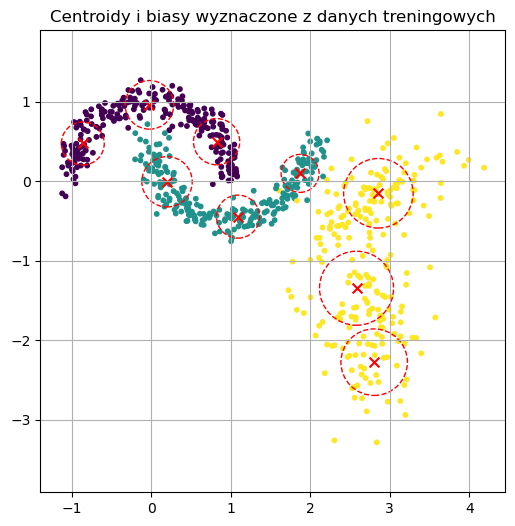

In [22]:
plt.figure(figsize=(6, 6))
plt.title("Centroidy i biasy wyznaczone z danych treningowych")
plt.scatter(X_train2[:, 0], X_train2[:, 1], c=y_train2, cmap="viridis", s=10)

for i in range(len(centroids_array)):
    cx, cy = centroids_array[i]
    r = biases_array[i]
    plt.scatter(cx, cy, color="red", marker="x", s=50)
    circle = patches.Circle((cx, cy), r, color='red', fill=False, linestyle='--')
    plt.gca().add_patch(circle)

plt.axis('equal')
plt.grid(True)
plt.show()

Wizualizacja pokazuje wyznaczone centroidy i biasy dla neuronów warstwy ukrytej, oparte na lokalizacji danych treningowych. Zastosowano podejście odwrotne do uczenia — zamiast trenować sieć, neurony rozmieszczono na podstawie wcześniejszej analizy rozkładu danych.

Centroidy (czerwone krzyżyki) zostały rozłożone równomiernie wzdłuż struktur klas, a promienie biasów (czerwone okręgi) dopasowano do lokalnej gęstości danych. Metoda ta zapewnia dobre pokrycie przestrzeni i tworzy warstwę ukrytą o intuicyjnej interpretacji geometrycznej, nawet bez wcześniejszego uczenia.

### 2.3 Inicjalizacja sieci neuronowej z wyznaczonymi wcześniej centroidami i biasami

W tej komórce konstruujemy jednowarstwową sieć MLP, której warstwa ukryta ma wagi równe współrzędnym centroidów, a biasy ustawione na podstawie promieni wyznaczonych wcześniej okręgów.

Sprawdzamy dokładność klasyfikacji na zbiorze treningowym i testowym **bez uczenia – tylko z inicjalizacją**.


Normalizacja danych i ich konwersja do tensora

In [23]:
scaler2 = StandardScaler()
X_train2_scaled = scaler2.fit_transform(X_train2)
X_test2_scaled = scaler2.transform(X_test2)

X_train2_tensor = torch.tensor(X_train2_scaled, dtype=torch.float32)
y_train2_tensor = torch.tensor(y_train2, dtype=torch.long)
X_test2_tensor = torch.tensor(X_test2_scaled, dtype=torch.float32)
y_test2_tensor = torch.tensor(y_test2, dtype=torch.long)


Definicja sieci i inicjalizacja modelu

In [24]:
class CustomInitMLP(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=9, output_dim=3):
        super().__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

        self.fc1.weight.data = torch.tensor(centroids_array, dtype=torch.float32)
        self.fc1.bias.data = torch.tensor(biases_array, dtype=torch.float32)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        return self.fc2(x)

custom_model = CustomInitMLP(input_dim=2, hidden_dim=hidden_dim, output_dim=3)


Ewaluacja bez wcześniejszego uczenia modelu

In [25]:
custom_model.eval()
with torch.no_grad():
    y_train2_pred = custom_model(X_train2_tensor).argmax(dim=1).numpy()
    y_test2_pred = custom_model(X_test2_tensor).argmax(dim=1).numpy()

print("Dokładność (trening):", accuracy_score(y_train2, y_train2_pred))
print("Dokładność (test):", accuracy_score(y_test2, y_test2_pred))

Dokładność (trening): 0.20555555555555555
Dokładność (test): 0.21666666666666667


Wyniki pokazują, że sieć zainicjalizowana wyłącznie na podstawie centroidów i biasów osiąga bardzo niską dokładność (ok. 21% dla obu zbiorów). Pomimo intuicyjnego rozmieszczenia neuronów w przestrzeni wejściowej, ich odpowiedzi nie wystarczają do skutecznego rozróżniania klas.

Samo dopasowanie geometryczne nie przekłada się bezpośrednio na dobrą klasyfikację — brak mechanizmu dostrajającego wagi (jak backpropagation) powoduje, że sieć nie uczy się zależności pomiędzy cechami a etykietami.


### 2.4 Dalsze uczenie sieci metodą backpropagation i wizualizacja po nauce

W tej komórce douczamy wcześniej zainicjalizowaną sieć neuronową z użyciem metody backpropagation. Następnie wykonujemy dwa wykresy:
- dane treningowe z centroidami warstwy ukrytej i biasami,
- dane testowe z tymi samymi elementami.

Pozwoli to zaobserwować, jak zmieniły się parametry sieci w wyniku uczenia.


Kopiujemy model, żeby nie nadpisać inicjalizacji oraz wyznaczamy optymalizator i funkcję kosztu

In [26]:
trained_model = CustomInitMLP(input_dim=2, hidden_dim=hidden_dim, output_dim=3)

optimizer = torch.optim.Adam(trained_model.parameters(), lr=0.01)
loss_fn = nn.CrossEntropyLoss()

Faktyczny trening oraz ewaluacja modelu

In [27]:
epochs = 200
for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = trained_model(X_train2_tensor)
    loss = loss_fn(outputs, y_train2_tensor)
    loss.backward()
    optimizer.step()

# Ewaluacja po treningu
trained_model.eval()
with torch.no_grad():
    y_train2_trained = trained_model(X_train2_tensor).argmax(dim=1).numpy()
    y_test2_trained = trained_model(X_test2_tensor).argmax(dim=1).numpy()

print("Dokładność po douczeniu (trening):", accuracy_score(y_train2, y_train2_trained))
print("Dokładność po douczeniu (test):", accuracy_score(y_test2, y_test2_trained))

Dokładność po douczeniu (trening): 0.925
Dokładność po douczeniu (test): 0.9388888888888889


Po przeprowadzeniu uczenia metodą backpropagation, sieć znacząco poprawiła swoją skuteczność — dokładność wzrosła do 92.5% na zbiorze treningowym i 93.9% na testowym.

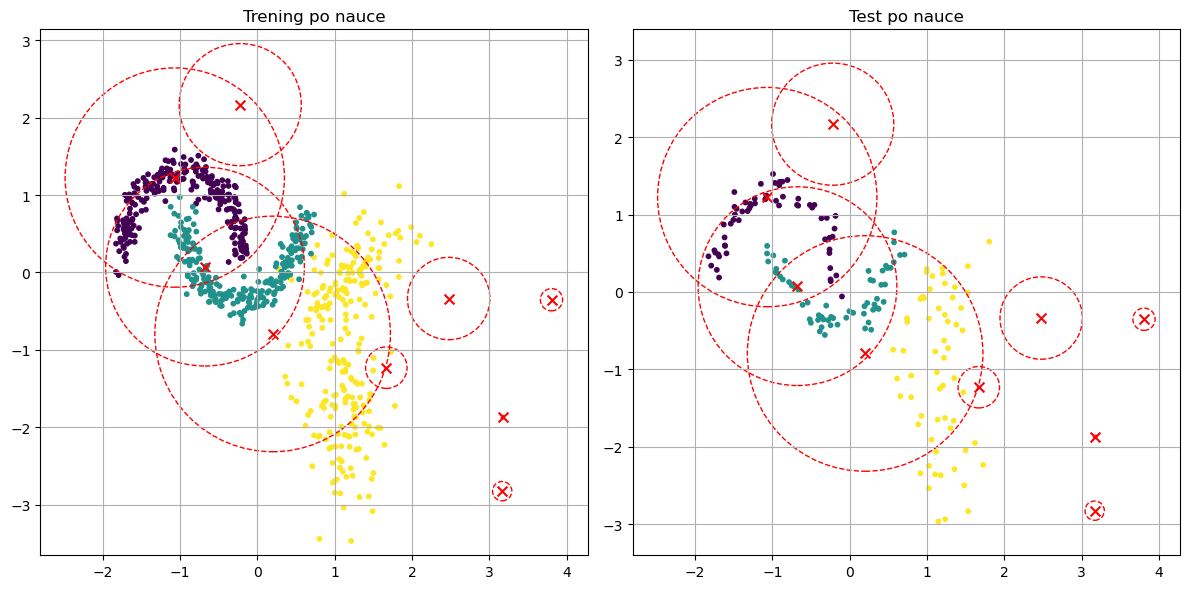

In [28]:

with torch.no_grad():
    trained_weights = trained_model.fc1.weight.numpy()
    trained_biases = trained_model.fc1.bias.numpy()

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
titles = ["Trening po nauce", "Test po nauce"]
datasets = [(X_train2_scaled, y_train2), (X_test2_scaled, y_test2)]

for ax, (X_set, y_set), title in zip(axes, datasets, titles):
    ax.set_title(title)
    ax.scatter(X_set[:, 0], X_set[:, 1], c=y_set, cmap="viridis", s=10)
    for i in range(trained_weights.shape[0]):
        cx, cy = trained_weights[i]
        bias = np.abs(trained_biases[i])
        ax.scatter(cx, cy, color="red", marker="x", s=50)
        circle = patches.Circle((cx, cy), bias, color='red', fill=False, linestyle='--')
        ax.add_patch(circle)
    ax.axis('equal')
    ax.grid(True)

plt.tight_layout()
plt.show()

Po douczeniu sieci metodą backpropagation neurony warstwy ukrytej uległy wyraźnemu przemieszczeniu, a ich promienie (biasy) zostały dostosowane do struktury danych. W porównaniu do stanu początkowego można zauważyć kilka istotnych zmian:

- Część centroidów przesunęła się bliżej granic klas, gdzie rozdzielenie jest trudniejsze. To sugeruje, że sieć nauczyła się lokalizować neurony tam, gdzie są najbardziej potrzebne do rozróżnienia klas.
- Promienie niektórych okręgów uległy powiększeniu, co pozwala neuronowi aktywować się w szerszym zakresie i lepiej reagować na dane z różnych klas.
- Inne neurony przeciwnie — zostały zawężone lub przesunięte na obrzeża, gdzie ich udział w klasyfikacji może być bardziej wyspecjalizowany.

W efekcie sieć zwiększyła pokrycie przestrzeni wejściowej w sposób dostosowany do rzeczywistego przebiegu granic klas. Wizualizacja pokazuje, że pozycje neuronów i ich biasy przestają być jedynie geometrycznymi reprezentacjami klas, a stają się funkcjonalnymi elementami przekształcenia danych — skutecznie wspierającymi decyzje klasyfikacyjne.


### Wnioski końcowe – porównanie obu metod

Zrealizowano dwa podejścia do konstrukcji sieci MLP dla danych z nieliniowymi granicami:

#### Metoda 1: Klasyczne podejście (trening od zera)
W pierwszym zadaniu sieć MLP została wytrenowana klasycznie — poprzez inicjalizację losową i optymalizację metodą backpropagation. Po zakończeniu uczenia:
- Centroidy neuronów warstwy ukrytej przemieściły się w rejonach granic klas i rozłożyły adaptacyjnie.
- Biasy neuronów przyjęły różne wartości, pozwalając im aktywować się lokalnie lub globalnie, w zależności od potrzeb.
- Wysoka dokładność (prawie 100%) świadczyła o skuteczności dopasowania sieci do danych, a wizualizacje (t-SNE, scatterploty) potwierdziły, że sieć nauczyła się rozdzielać dane w przestrzeni ukrytej.

#### Metoda 2: Odwrotna – inicjalizacja z danych
W drugim zadaniu odwrócono schemat: najpierw wyznaczono rozmieszczenie neuronów warstwy ukrytej na podstawie danych (za pomocą centroidów i biasów), a dopiero potem wykorzystano je jako inicjalizację.
- Wstępna dokładność była bardzo niska (~21%), mimo że centroidy pokrywały obszary danych. To pokazuje, że samo dopasowanie geometryczne nie wystarcza do poprawnej klasyfikacji.
- Po douczeniu sieć osiągnęła wysoką dokładność (~93%), a wizualizacja wykazała duże zmiany w rozmieszczeniu neuronów — część z nich została aktywowana i przesunięta tam, gdzie sieć ich najbardziej potrzebowała.

#### Porównanie
- Metoda 1 jest niezawodna i skuteczna, ale całkowicie oparta na losowej inicjalizacji i działaniu optymalizacji.
- Metoda 2 pozwala wprowadzić pewne założenia co do lokalizacji aktywacji — daje intuicyjny wgląd w to, jak neurony mogą być wstępnie rozłożone, choć bez uczenia nie prowadzi do dobrych wyników.

#### Wnioski
Metodyczne rozmieszczenie neuronów może ułatwić start procesu uczenia, ale dopiero mechanizm backpropagation nadaje im funkcjonalne znaczenie. Najlepsze rezultaty osiąga się, łącząc dobrą inicjalizację z pełnym procesem optymalizacji.
